# Comparison of SVERAD and SHAP on the RBF kernel for 50 random compounds.

In [1]:
from src.sverad_kernel import compute_sverad_sv, rbf_kernel_matrix, rbf_kernel_matrix_sparse
from src.utils import set_seeds, DataSet, UnfoldedMorganFingerprint

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

from scipy.stats import pearsonr
from tqdm.auto import tqdm
import warnings
import shap

In [2]:
SEED = 42
set_seeds(SEED)
GAMMA = 0.05 #0.01  #1.0 0.005 

SAVE_DATASET_PICKLE = False
LOAD_DATASET_PICKLE = True
LOAD_PRECOMPUTED_EXPLANATIONS = True
SAVE_EXPLANATIONS = False
SAMPLE_SIZE = 50

save_path = "./data/pickle/explanations_50_cpd_rbf_SVERAD_SHAP.p"

### Load and generate dataset

In [3]:
dataset_df = pd.read_csv("data/dataset.tsv", sep="\t")
dataset_df.pivot_table(index="uniprot_id", columns="label", values="nonstereo_aromatic_smiles", aggfunc="nunique", fill_value=0)

label,active,random
uniprot_id,,
P0DMS8,287,287


In [4]:
dataset_dict = dict()
fingerprint_gen_dict = dict()

if not LOAD_DATASET_PICKLE:
    for dataset_name, data_grpd_df in dataset_df.groupby("uniprot_id"):
        
        # label: 1: active, 0: random
        labels = np.array([1 if l == 'active' else 0 for l in data_grpd_df.label])
        # Creating Fingerprint
        morgan_radius2 = UnfoldedMorganFingerprint(radius=2)
        morgan_radius2.fit_smiles(data_grpd_df.nonstereo_aromatic_smiles.tolist())
        
        # Constructing Dataset
        fp_matrix = morgan_radius2.transform_smiles(data_grpd_df.nonstereo_aromatic_smiles.tolist())
        # Constructing Dataset
        dataset = DataSet(labels, fp_matrix)
        dataset.add_attribute("nonstereo_aromatic_smiles", data_grpd_df.nonstereo_aromatic_smiles.values)
        
        dataset_dict[dataset_name] = dataset
        fingerprint_gen_dict[dataset_name] = morgan_radius2

#### Save/load dataset and fingerprint for future use

In [5]:
if SAVE_DATASET_PICKLE:
    with open("./data/pickle/dataset_dict.p", "wb") as outfile:
        pickle.dump(dataset_dict, outfile)
    with open("./data/pickle/fingerprint_gen_dict.p", "wb") as outfile:
        pickle.dump(fingerprint_gen_dict, outfile)
if LOAD_DATASET_PICKLE:
    with open("./data/pickle/dataset_dict.p", "rb") as infile:
        dataset_dict = pickle.load(infile)
    with open("./data/pickle/fingerprint_gen_dict.p", "rb") as infile:
        fingerprint_gen_dict = pickle.load(infile)

# Analysis

In [6]:
dataset = dataset_dict["P0DMS8"]

In [7]:
print("Number of CPDs: {}\nNumber of features: {}".format(*dataset.feature_matrix.shape))

Number of CPDs: 574
Number of features: 5487


In [8]:
if not LOAD_PRECOMPUTED_EXPLANATIONS: # This takes about 6-7h
    explanation_df = []
    # Selecting a random subset
    subset = shap.sample(dataset.feature_matrix, nsamples=SAMPLE_SIZE, random_state=SEED)

    # Iterating over all pairs.
    for i, arr_i in tqdm(enumerate(subset), total=SAMPLE_SIZE):
        
        
        
        # kernel_func = lambda x: rbf_kernel_matrix(x.toarray(), arr_i.toarray().reshape((1, -1)), gamma = GAMMA)[:, 0] #with np.array
        kernel_func = lambda x: rbf_kernel_matrix_sparse(x, arr_i, gamma = GAMMA)[:, 0] #with sparse matrix
        
        for j, arr_j in tqdm(enumerate(subset), total=SAMPLE_SIZE):
            if i == j:
                continue
            
            # intersection_ij = arr_i.toarray()[0] * arr_j.toarray()[0]
            # union_ij = 1 - (1-arr_i.toarray()[0]) * (1-arr_j.toarray()[0])
            # diff_ij = union_ij - intersection_ij
            # sveta_values_ij = intersection_ij * sveta_f_plus(sum(intersection_ij), sum(diff_ij))
            # sveta_values_ij += diff_ij * sveta_f_minus(sum(intersection_ij), sum(diff_ij))

            sverad_values_ij = compute_sverad_sv(arr_i.toarray()[0], arr_j.toarray()[0], gamma=GAMMA)
            
            # removing CPDs of the pair from the background sample.
            mask = np.ones(subset.shape[0], dtype=bool)
            mask[i] = False
            mask[j] = False
            available_as_sample = subset[mask]
            
            with warnings.catch_warnings():
                # ignore all caught warnings
                warnings.filterwarnings("ignore")
                explainer_vi = shap.KernelExplainer(kernel_func, available_as_sample)
                
                # kernel_value = rbf_kernel_matrix(arr_i.toarray(), arr_j.toarray(), gamma = GAMMA) 
                kernel_value = rbf_kernel_matrix_sparse(arr_i, arr_j, gamma = GAMMA) 
                shap_ij = explainer_vi.shap_values(arr_j, silent=True)
                
            explanation_df.append({"instance a": i,
                                   "instance b": j,
                                   "RBF kernel value": kernel_value[0][0],
                                   "SVERAD": sverad_values_ij,
                                   "SHAP": shap_ij[0],
                                   "SHAP_expected_value": explainer_vi.expected_value,
                                   })
        #break
    explanation_df = pd.DataFrame(explanation_df)
    if SAVE_EXPLANATIONS:
        with open(save_path, "wb") as outfile:
            pickle.dump(explanation_df, outfile)
else:
    with open(save_path, "rb") as infile:
        explanation_df = pickle.load(infile)

In [9]:
# rbf_kernel_matrix(arr_i.toarray(), arr_j.toarray(), gamma = GAMMA)[:, 0]

In [10]:
# rbf_kernel_optimized(2, gamma=GAMMA)

In [11]:
# compute_sverad_sv(arr_i.toarray()[0], arr_j.toarray()[0], gamma=GAMMA).sum()

In [12]:
# rbf_kernel_matrix(arr_i.toarray(), arr_j.toarray(), gamma = GAMMA)[:, 0]
# x = np.array([1, 0, 1, 0, 1, 0, 1, 0])
# y = np.array([1, 1, 1, 1, 1, 1, 1, 1])

# rbf_kernel(x, y, gamma = GAMMA)

In [13]:
# intersection_xy = x * y  # Vector where intersecting features are set to 1
# union_xy = 1 - (1-x) * (1-y)  # Vector where features of the union are set to 1
# diff_xy = union_xy - intersection_xy  # Vector where features from the symmetric difference are set to 1

# num_intersecting_features = sum(intersection_xy)
# num_difference_features = sum(diff_xy)
# num_difference_features
# rbf_kernel_optimized(num_difference_features, gamma=GAMMA)

In [14]:
# compute_sverad_sv(x, y, gamma=GAMMA).sum()
explanation_df.loc[15]["SVERAD"].sum()

0.0031827807965097953

In [15]:
# explanation_df.loc[3]["SHAP"].sum()

In [16]:
# explanation_df.loc[3]["RBF kernel value"] - explanation_df.loc[3]["SHAP_expected_value"]

In [17]:
explanation_df

,instance a,instance b,RBF kernel value,SVERAD,SHAP,SHAP_expected_value
0,0,1,0.008652,"[0.009345794392523364, 0.009345794392523364, 0...","[0.0, 0.0, 0.00018125685386479774, 0.0, -0.000...",0.026794
1,0,2,0.002243,"[0.007352941176470588, 0.007352941176470588, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -8.470761611518...",0.026928
2,0,3,0.012907,"[0.009615384615384616, 0.009615384615384616, 0...","[0.0, 0.0, 0.0, 0.0002040759550344651, -0.0007...",0.026706
3,0,4,0.007447,"[0.009009009009009009, 0.009009009009009009, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0002295086294...",0.026819
4,0,5,0.105399,"[0.01098901098901099, 0.01098901098901099, 0.0...","[0.0, 0.0, 0.0, 0.00022760309834060286, 0.0, 0...",0.024779
...,...,...,...,...,...,...
2445,49,44,0.157237,"[0.012195121951219513, 0.012195121951219513, 0...","[0.0, 0.0, 0.0, 0.0, 0.001278187346164745, 0.0...",0.042932
2446,49,45,0.116484,"[0.012658227848101266, 0.012658227848101266, 0...","[0.0, 0.0, 0.0, -0.00230955031641038, 0.000853...",0.043781
2447,49,46,0.007828,"[0.009259259259259259, 0.009259259259259259, -...","[0.0, 0.0, -0.0006582909760202149, -0.00060175...",0.046044
2448,49,47,0.005799,"[0.008928571428571428, 0.008928571428571428, 0...","[0.0, 0.0, 0.0, 0.0, -0.00027792415599205237, ...",0.046087


### Correlation

In [18]:
corr_df = []
for i, row in explanation_df.iterrows():
    if row["instance a"] == row["instance b"]:
        continue
    sverad_value = row["SVERAD"]
    shap = row["SHAP"]
    
    
    corr_sverad_SHAP, p_sverad_SHAP = pearsonr(sverad_value, shap)
    
    
    corr_df.append({"a": row["instance a"], "b": row["instance b"],  "Pearson r SVERAD - SHAP": corr_sverad_SHAP})
corr_df = pd.DataFrame(corr_df)
corr_df["Fisher SVERAD - SHAP"] = np.arctanh(corr_df["Pearson r SVERAD - SHAP"])
# corr_df["Pearson r Fisher Tranformed"] = np.tanh(corr_df["Fisher SVERAD - SHAP"])
display(corr_df)
print("Mean correlation")
display(corr_df.mean())
print("Standard deviation")
display(corr_df.std())

print("Mean Pearson r correlation coeff for SVERAD - SHAP: ", corr_df["Pearson r SVERAD - SHAP"].mean(), "+/-", corr_df["Pearson r SVERAD - SHAP"].std())
print("Mean Pearson r correlation coeff Fisher transformed for SVERAD - SHAP: ", np.tanh(corr_df["Fisher SVERAD - SHAP"].mean()), "+/-", np.tanh(corr_df["Fisher SVERAD - SHAP"].std()))

,a,b,Pearson r SVERAD - SHAP,Fisher SVERAD - SHAP
0,0,1,0.340717,0.354904
1,0,2,0.243890,0.248906
2,0,3,0.543253,0.608759
3,0,4,0.356208,0.372536
4,0,5,0.653761,0.781839
...,...,...,...,...
2445,49,44,0.688470,0.845041
2446,49,45,0.731687,0.932349
2447,49,46,0.366909,0.384847
2448,49,47,0.270062,0.276931


Mean correlation


a                          24.500000
b                          24.500000
Pearson r SVERAD - SHAP     0.352736
Fisher SVERAD - SHAP        0.381396
dtype: float64

Standard deviation


a                          14.433816
b                          14.433816
Pearson r SVERAD - SHAP     0.138880
Fisher SVERAD - SHAP        0.182643
dtype: float64

Mean Pearson r correlation coeff for SVERAD - SHAP:  0.35273642023240137 +/- 0.13887961656298425
Mean Pearson r correlation coeff Fisher transformed for SVERAD - SHAP:  0.36391931794854354 +/- 0.1806388404529835


Old code

In [19]:
corr_df = []
for i, row in explanation_df.iterrows():
    if row["instance a"] == row["instance b"]:
        continue
    sveata_values = row["SVERAD"]
    kernel_shap = row["SHAP"]
    
    corr, p = pearsonr(sveata_values, kernel_shap)
    corr_df.append({"a": row["instance a"], "b": row["instance b"], "correlation": corr})
corr_df = pd.DataFrame(corr_df)
# Fisher transformation
corr_df["pearsons_r_fisher"] = np.arctanh(corr_df.correlation)

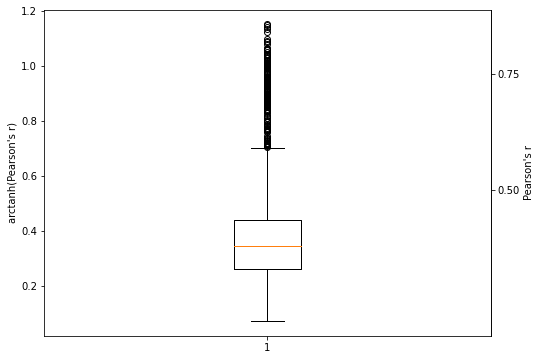

In [20]:
fig, ax = plt.subplots(figsize=(8,6))
ax.boxplot(corr_df.pearsons_r_fisher)
#ax.set_ylim(-0.1,4.05)
ax.set_ylabel("arctanh(Pearson's r)")
secax = ax.secondary_yaxis('right', functions=(np.tanh, np.arctanh))
secax.set_ylabel("Pearson's r")
secax.set_yticks([-0.5, 0, 0.5, 0.75, 0.9]);

In [21]:
# Transforming values back.

In [22]:
np.tanh(corr_df["pearsons_r_fisher"].mean())

0.36391931794854354

In [23]:
np.tanh(corr_df["pearsons_r_fisher"].std())

0.1806388404529835

In [24]:
np.tanh(corr_df["pearsons_r_fisher"].min())

0.07388989940187711

In [25]:
np.tanh(corr_df["pearsons_r_fisher"].max())

0.8183148051850931